In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.ardl import ARDL

import numpy as np
import os 
import sys
#sys.path.append("../src/model")
sys.path.append(os.path.abspath("../../src/model/"))

from pprint import pprint

from ARDL_model import *

DATA_PATH_CLEAN = "../data/CLEAN"

DATA_PATH = "../../data/CLEAN/FBI_Dataset_91_12/RAW/"



In [52]:
# Let's take an example with the state of Alabama
state = "Alabama"

single_state_data = pd.read_csv(DATA_PATH+ state+"_violence.csv", sep=",")
display(single_state_data)

,incident_id,incident_date,offense_category_name,year,date,week
0,66036917,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
1,66036920,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
2,66036922,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
3,66036923,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
4,66036924,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
...,...,...,...,...,...,...
347838,64304,1991-11-30 00:00:00,Larceny/Theft Offenses,1991,1991-11-30,48
347839,64307,1991-12-15 00:00:00,Larceny/Theft Offenses,1991,1991-12-15,50
347840,64306,1991-12-18 00:00:00,Larceny/Theft Offenses,1991,1991-12-18,51
347841,64305,1991-12-19 00:00:00,Larceny/Theft Offenses,1991,1991-12-19,51


In [43]:
single_state_data.sort_values(by=['year', 'week'], inplace=True)
print("The unique years in {} data spam from {} to {}".format(state,single_state_data.year.min(), single_state_data.year.max()))
print("The unique weeks in {} data spam from {} to {}".format(state, single_state_data.week.min(), single_state_data.week.max()))
#We cut to 2012 because we don't have the box offices of the movies after this year
single_state_data_data_matched = single_state_data[single_state_data.year < 2013]

The unique years in Alabama data spam from 1991 to 2012
The unique weeks in Alabama data spam from 1 to 53


In [3]:
# Obtain all the states names
all_states_names= os.listdir(DATA_PATH)

In [4]:
# Collect all the states files in a dictionary for easy access 
states_data = {}

for state in all_states_names:
    states_data[state[:-13]] = pd.read_csv(DATA_PATH+state, sep=",")# Use state name as key 


# Plots

Let's see just one state, still our old Alabama !

We have decided to limit our analysis to 6 offense categories. But how do they look like ? Do we see anything special ? 

"Plot, you should, acquire knowledge, you will." tells Ada. 

Let's listen to this wise advice. Since it consists only in a preliminary analysis, let's restrict ourself to only one year and observe the different patterns accross the weeks. 

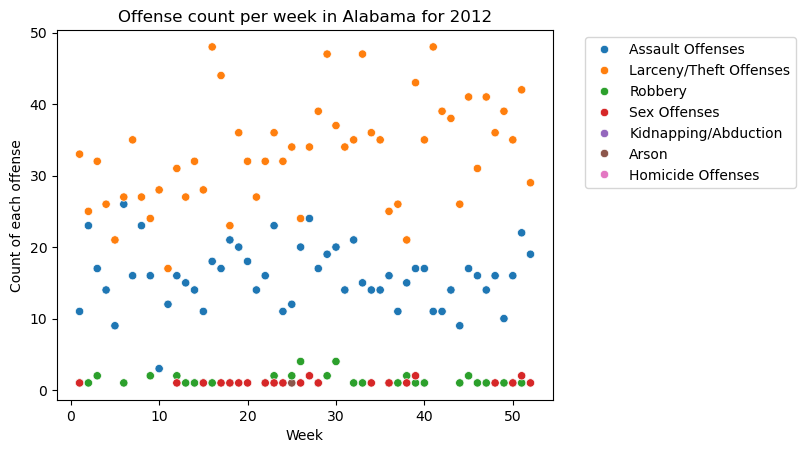

In [44]:
import seaborn as sns
year = 2012

# Obtain the number of each class per year per week 
group_sizes = single_state_data.groupby(["year", "week", "offense_category_name"]).size()

# Reset the index and name the size column
result_df = group_sizes.reset_index(name='count_of_offenses')
sns.scatterplot(result_df[result_df.year==year], x='week', y='count_of_offenses',hue='offense_category_name')
plt.xlabel("Week")
plt.ylabel("Count of each offense")
plt.title("Offense count per week in {} for {}".format(state,year))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

There is a huge disparities among the offenses, Larceny/Theft Offenses being at the top followed closely by Assault Offenses. Can we visualise it in another way to gain more insight and ease comparison ? Heatmaps to the rescue !

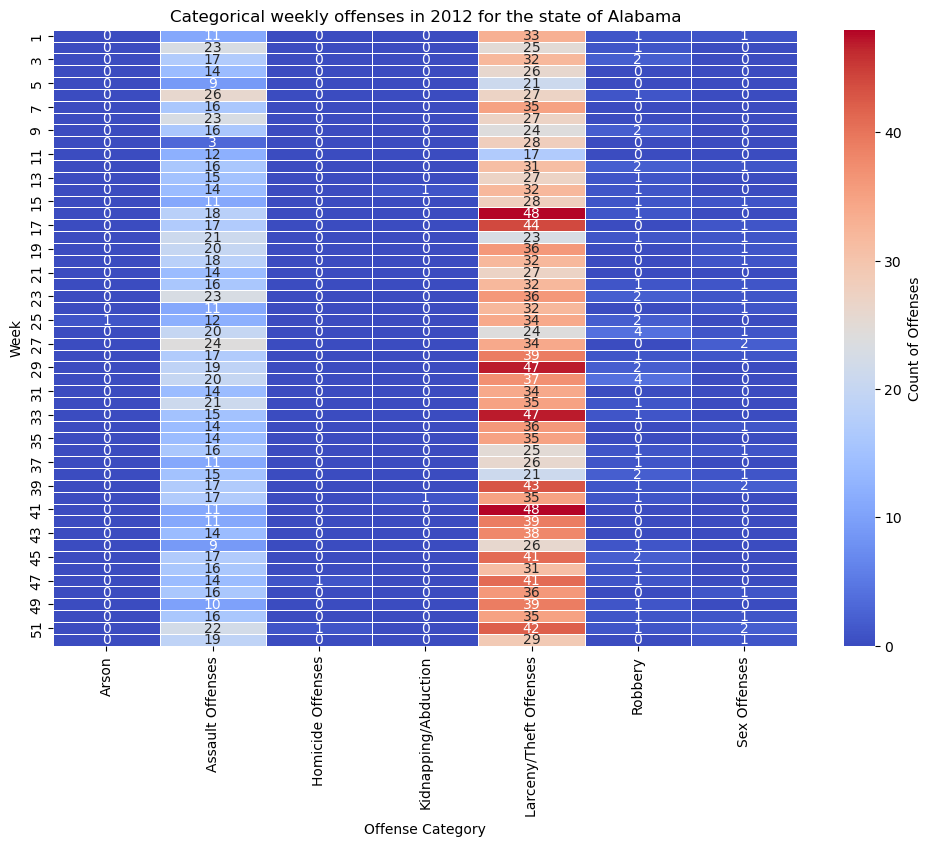

In [48]:
heatmap_data = result_df[result_df.year == year].pivot(index="week", columns="offense_category_name", values="count_of_offenses")
heatmap_data.fillna(0, inplace=True)  # Fill NaN values with 0

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5,cbar_kws={'label': 'Count of Offenses'} ) 
plt.title('Categorical weekly offenses in {} for the state of {}'.format(year,state))
plt.ylabel('Week')
plt.xlabel('Offense Category')
plt.show()

The disparities are even clearer now. Larceny/Theft Offenses shadow all other offenses, at least for the year 2012, points out Ada. What about accross the years ? For that, we need to know more about the years our data spam. 


# Data manipulation

In [49]:
# Store all years for each state in a dictionary
states_years = {}
for state in all_states_names:
    states_years[state[:-13]] = sorted(states_data[state[:-13]].year.unique())


In [ ]:
# Create a presence DataFrame for all the states
presence_df = pd.DataFrame(index= states_data.keys(),columns=np.arange(1991,2013))# Again restrict to 1991-2013 due to box-office constrainsts

# Populate the DataFrame
for state, years in states_years.items():
    presence_df.loc[state, years] = 1 # If the state has data for that year, set to 1

presence_df.fillna(0, inplace=True)# If the state does not have data for that year, set to 0



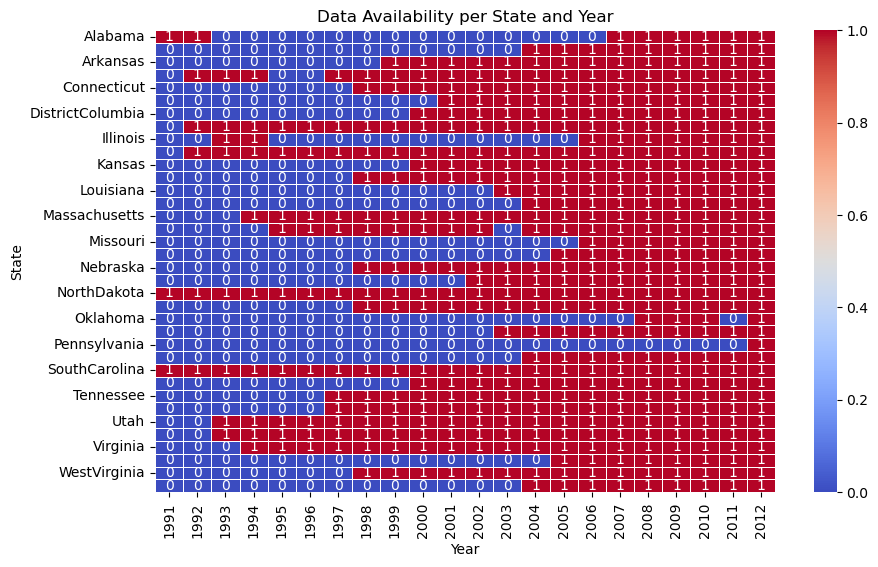

In [50]:
# Visualise the years spam for each state
plt.figure(figsize=(10, 6))
sns.heatmap(presence_df, annot=True, cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Data Availability per State and Year')
plt.ylabel('State')
plt.xlabel('Year')
plt.show()

"Phew, we narrowly avoided a disaster! As good as the Croco FBI may be, it seems there are some issues with their data collection..." says Ada. 

"Hey, no ones is perfect Ada" reply an offuscated Crocolock. 

"For sure, let's move on, shall we" says our very pragmatic Ada.  

In [35]:
# Data for Florish heatmap 
heatmap_data.to_csv('../../data/CLEAN/heatmap_data.tsv', sep="\t", index=False)

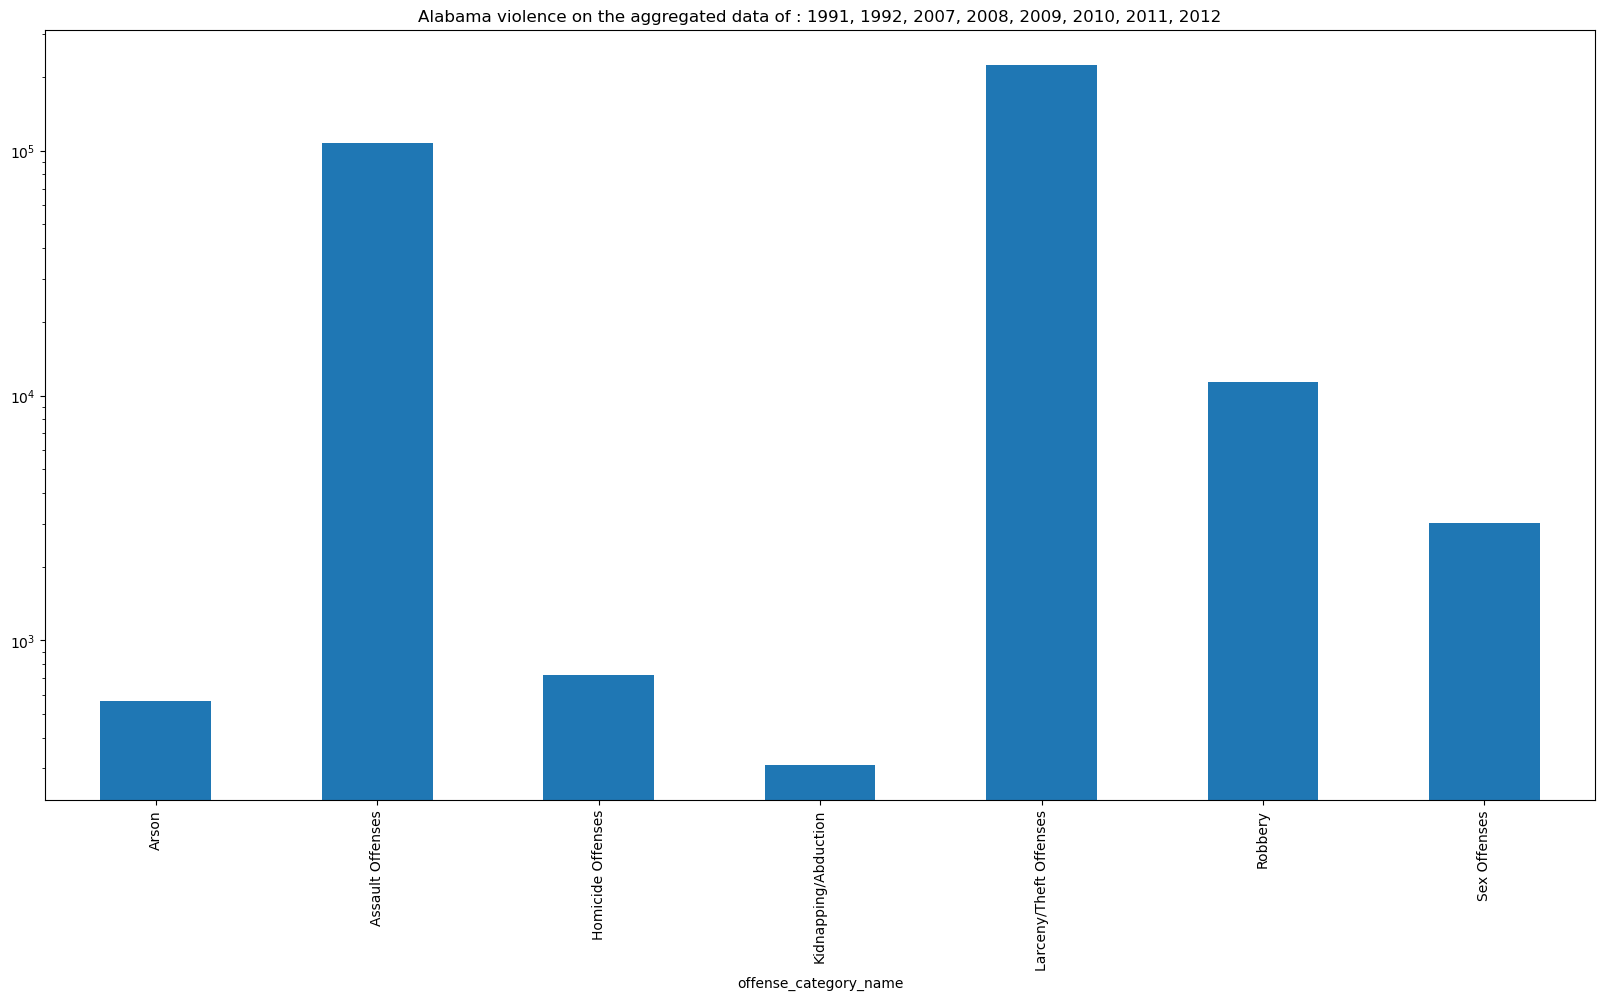

In [58]:
years_str = ", ".join(map(str, states_years[state]))
plt.figure(figsize=(20,10))
states_data[state].groupby("offense_category_name").size().plot(kind="bar",logy=True)
plt.title(state +" violence on the aggregated data of : {}".format(years_str))
plt.show()

Interesting! The trend seems to remain, all available years combined. But maybe it is a localised phenomenon, what about the other states ?

Thanks to our earlier analysis, we know we can safely consider the year 2012 to compare accross states. Reminder here that we only have data for 36 out of 50 states! Let's keep this in mind. 



In [60]:
def longest_consecutive_sequence(sorted_years):
    """
    Finds the longest consecutive sequence of years in a sorted list of integers.

    Args:
        sorted_years (list[int]): A list of integers representing years, sorted in ascending order.

    Returns:
        list[int]: A list containing the longest consecutive sequence of years.
                   If there are multiple sequences of the same maximum length, the first one encountered is returned.

    Example:
        >>> longest_consecutive_sequence([2000, 2001, 2002, 2004, 2005, 2006, 2007])
        [2004, 2005, 2006, 2007]
    """
    # Initialize variables to track the longest sequence
    max_length = 1
    current_length = 1
    start_year = sorted_years[0]
    best_start = start_year

    # Iterate through the sorted list and find the longest consecutive sequence
    for i in range(1, len(sorted_years)):
        if sorted_years[i] == sorted_years[i-1] + 1:
            current_length += 1
        else:
            if current_length > max_length:
                max_length = current_length
                best_start = start_year
            # Reset for the next sequence
            start_year = sorted_years[i]
            current_length = 1

    # Check the last sequence
    if current_length > max_length:
        best_start = start_year
        max_length = current_length

    # Create the list of the longest consecutive sequence
    longest_sequence = list(range(best_start, best_start + max_length))
    return longest_sequence

In [61]:
states_years_consecutive = pd.DataFrame(index= states_data.keys(),columns=["minimum_year", "maximum year"])
for state in all_states_names:
    sequence = longest_consecutive_sequence(states_years[state[:-13]])
    states_years_consecutive.loc[state[:-13], "minimum_year"] = np.min(sequence)
    states_years_consecutive.loc[state[:-13], "maximum year"] = np.max(sequence)

/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_11879/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  

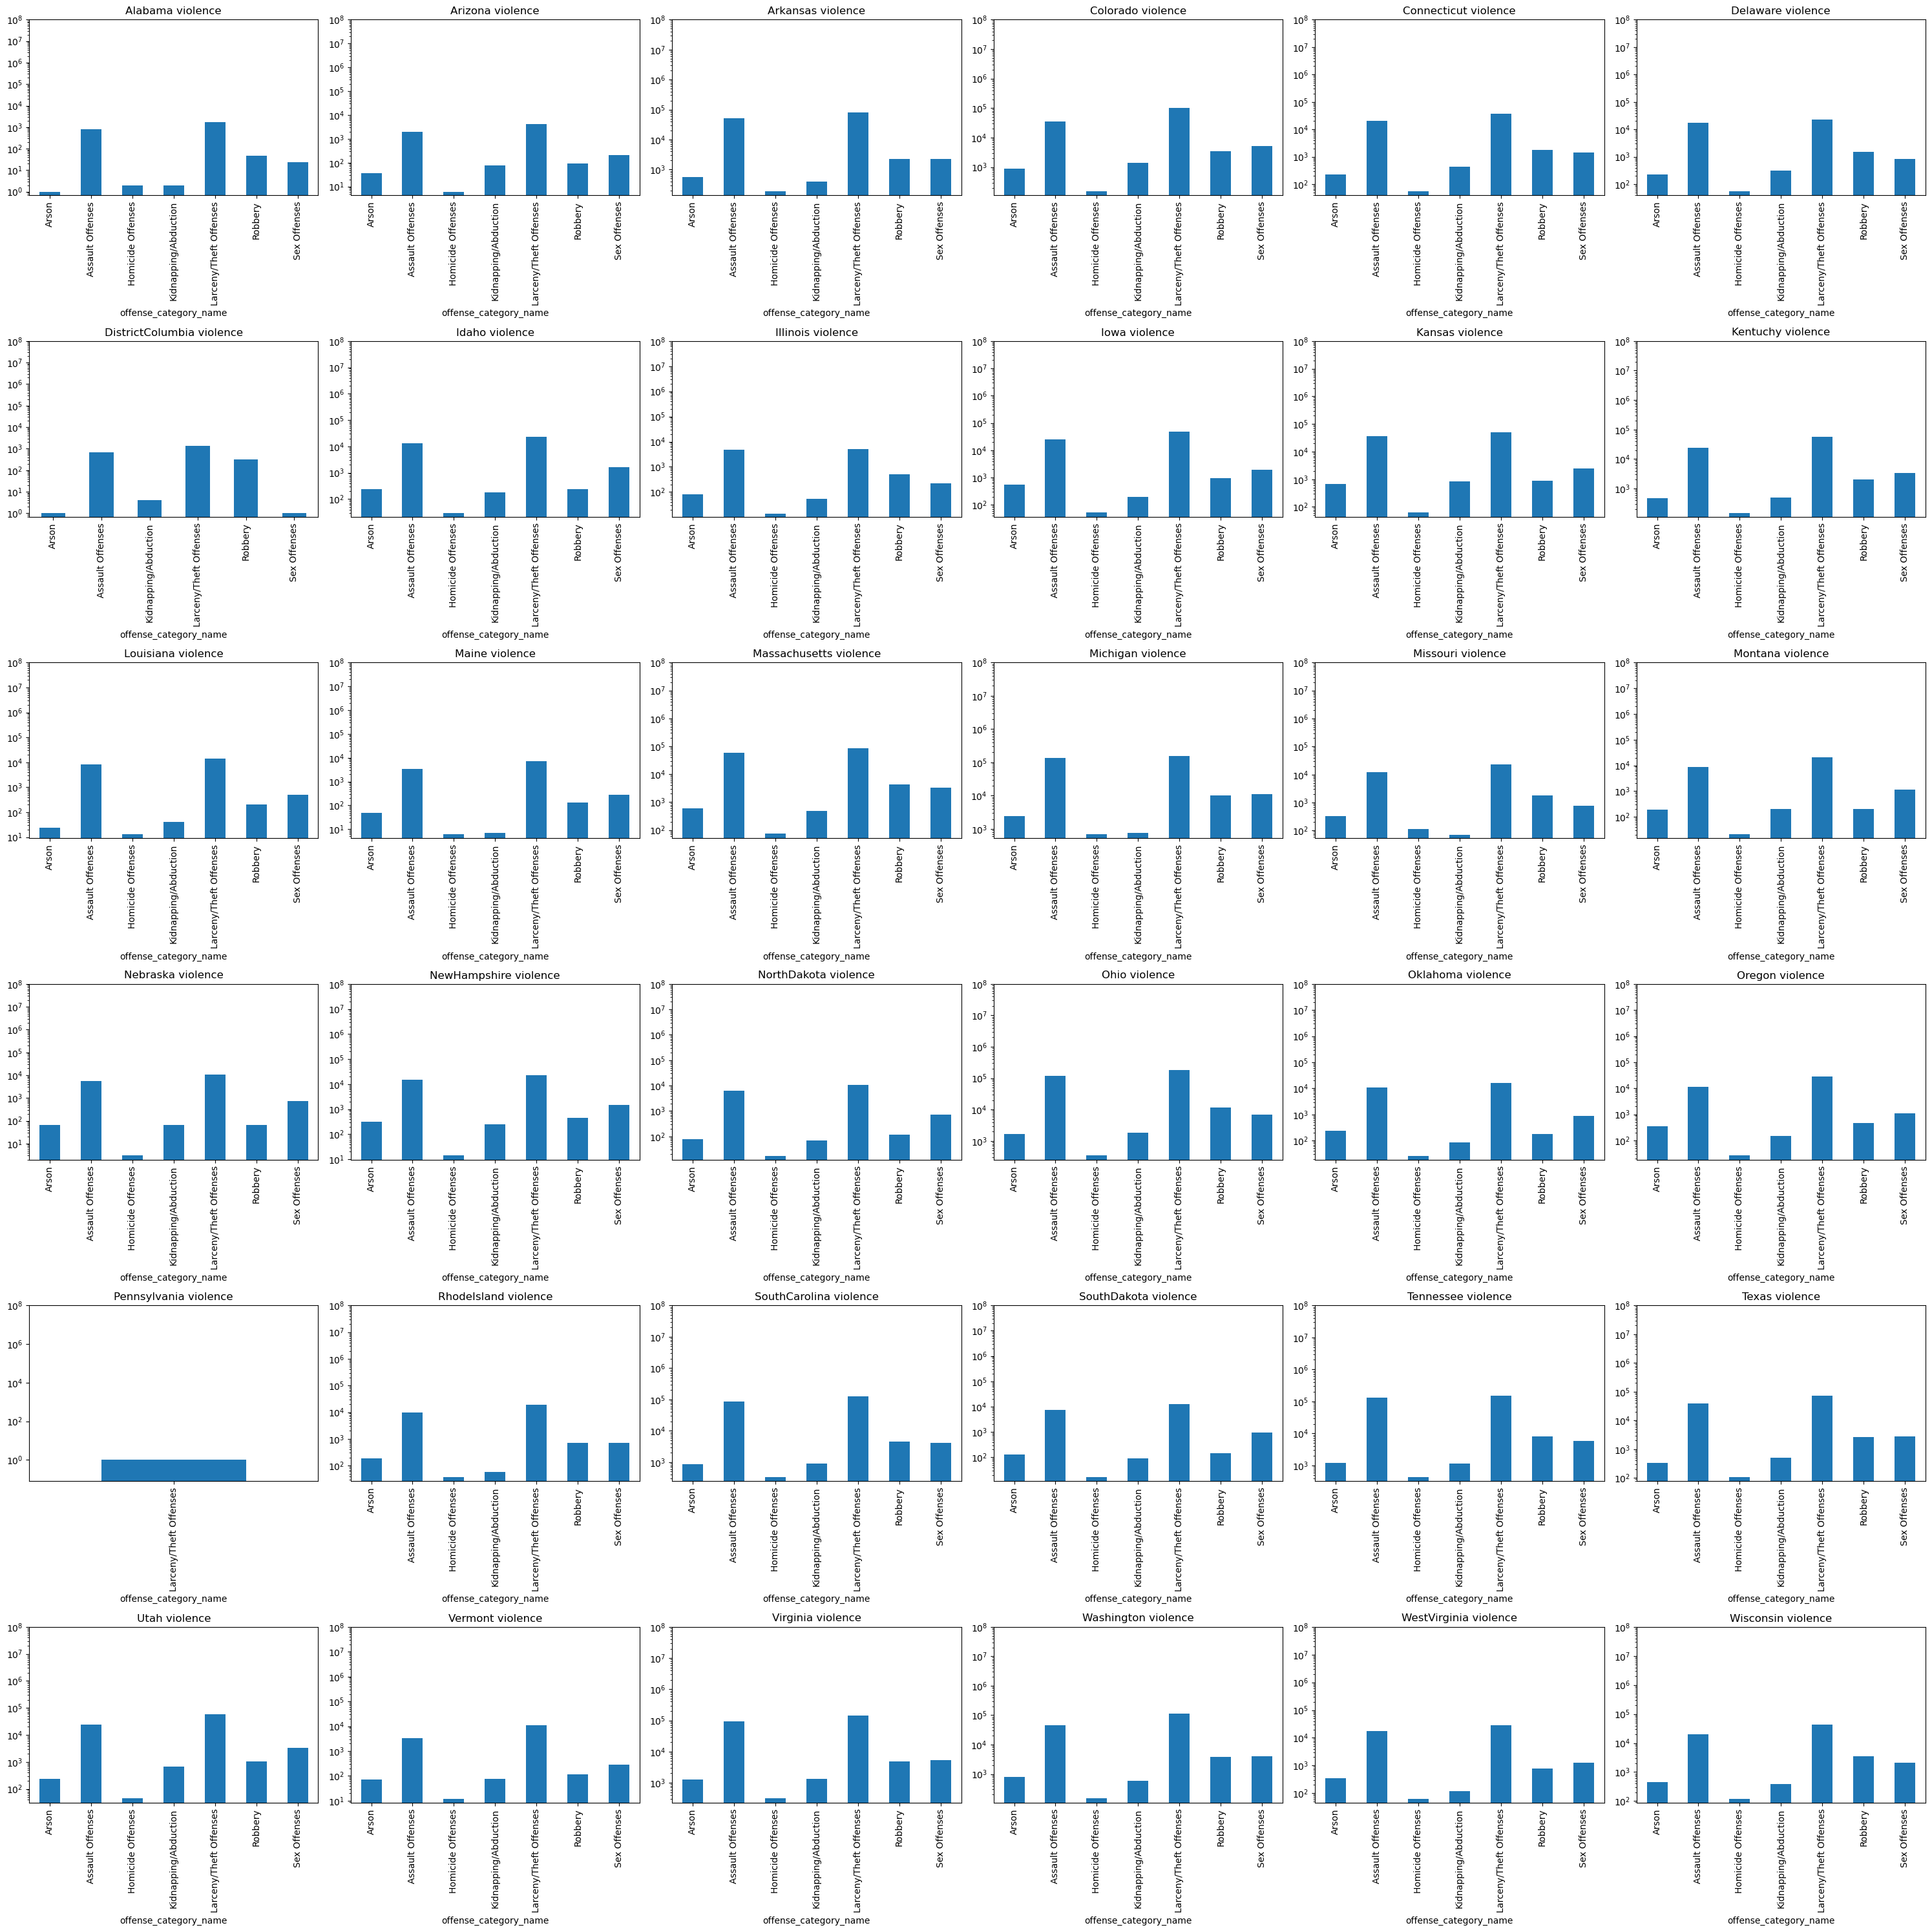

In [59]:
year = 2012
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(30, 30))
axes = axes.flatten()

for i, state in enumerate(all_states_names):
    ax = axes[i]
    states_data[state[:-13]][states_data[state[:-13]].year==year].groupby("offense_category_name").size().plot(kind="bar", logy=True, ax=ax)
    ax.set_title(state[:-13] + " violence")
    ax.set_ylim(0, 10**8)

plt.tight_layout()
plt.show()

"Hum..Not sure about your analysis Ada. Maybe you have drunk too much coffeine... Because it seems that nothing changes." states Crocolock, still a little bit annoyed by earlier comment.  

"It is true that those plots seem really close one to another but look carefully at the Robbery barplot between Washington and WestVirginia for instance, isn't there something happening ? Again apologise for my earlier comment, it wasn't deserved. "

"You are right! No hard feelings. Let's remove the Larcency/Theft Offense then."

Larcency/Theft Offense is removed. We now need to create a metric for the violent score. Counts, ratio, z-scores normalisation, min-max normalisation the list could go on. But since we are intersted in the time effect, we have to be careful not to include information from the future. 

"Indeed, it would be like doing time-travels, but we are not Marty and Dr. Emmet." points out Ada. Our professor is a quite well-versed in movies in case you wouldn't have noticed! 

We can do a first approximate by summing all couts per week no matter the category. 

In [14]:
#save the data 
#states_years_consecutive.to_csv(DATA_PATH +"/Consecutive_years_states.tsv", sep="\t")

# Score by count and count ratio

In [15]:
# Real life score for weeks 
def real_life_violence_score_count(data,year,start_week,stop_week,ratio=False): 
    extracted_data = data[(data.year==year) & (data.week >=start_week) & (data.week <=stop_week)]
    weekly_score = extracted_data.groupby("week").size()
    if ratio: 
        weekly_score/=len(extracted_data)

    return weekly_score


In [62]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify if you want the ratio or the count
real_life_violence_score_count(single_state_data,2008,10,14,True)


week
10    0.154206
11    0.182243
12    0.238318
13    0.214953
14    0.210280
dtype: float64

This approach allow a general picture but have the huge drawback of considering all offenses category equally violent and not take care of any imbalanced. 

"Let's take an example. Let imagine in week X 36 assaults have been commited but no homicide. Then week X+1, 1 assault and 35 murders has been commited. Those two weeks would appear equally violent, when their pattern isn't at all the same! How to correct this ? Z-score normalisation per category !" 

"Sorry, but what is z-score normalisation again ?"

"My apologies, I was too much into my thoughts. Here is a little explanation : 

 Z-score, also known as stantardisation is is a statistical technique used to rescale the values of a dataset so that they have a mean of 0 and a standard deviation of 1. This process helps to compare features on the same scale. To achieve that we substract the mean to each element and divide the result by the stantard deviation. It is particularly useful to be able to correct the issue mentionned just before !"

 "But you mentionned that we couldn't look into the future to process our data..."

 "Well done! You're a quick learner. Indeed we can't simply take the mean and stantard deviation of the whole period consider. But this can be solved with the concept of past causal window. This means that for a given position t in the time, the rolling window includes only the current value and the values prior to it. It therefore preserve the natural timescale of the events while scaling them so that they are comparable."

# Score taking into account the different categories of offenses 

In [18]:
def extraction_violence_data (data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Larceny/Theft Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
       """
        Extracts and summarizes violence-related data for specified offenses over a defined time period.

       Args:
        data (pd.DataFrame): The input dataset containing offense information.
        year (int): The year for which to extract data.
        start_week (int): The starting week number for the period of interest.
        stop_week (int): The ending week number for the period of interest.
        window_size (int): The number of weeks to consider for the moving average, default correspond to the maxiumum autolag of the ARDL model.
        offenses (list of str, optional): A list of offense categories to consider.

       Returns:
        pd.DataFrame: A DataFrame summarizing the extracted data between the specified year and weeks of interest. 

        """
       extracted_data = data[(data.year==year) & (data.week >=start_week) & (data.week <=stop_week)] 
       category_size = extracted_data.groupby(["year", "week", "offense_category_name"]).size()
       result_df = category_size.reset_index(name='count_of_offenses')
       return result_df
       

In [19]:
def normalise_violent_category(extracted_data, offense,window_size=6):
    """
    Computes rolling z-score normalization for a specific offense category.
    Args:
        extracted_data (pd.DataFrame): A DataFrame containing offense data
        offense (str): The name of the offense category to normalize
        window_size (int, optional): The size of the rolling window for calculating the mean and standard deviation, correspond to maximum autolag of ARLD model. 
    Returns:
        pd.DataFrame: A DataFrame containing the normalized data for the specified offense category.
    """ 

    if offense in extracted_data['offense_category_name'].values:
        extracted_category = extracted_data[extracted_data.offense_category_name == offense].copy()
        rolling_mean = extracted_category.count_of_offenses.rolling(window=window_size, min_periods=1).mean()
        rolling_std = extracted_category.count_of_offenses.rolling(window=window_size, min_periods=1).std().fillna(1) # avoid division by 0 and enable to have 0 as z-score since z-score not applicable in that case
        extracted_category.loc[:, 'z_score'] = (extracted_category.count_of_offenses - rolling_mean ) / rolling_std
    else: 
        extracted_category = pd.DataFrame()
    return extracted_category
    

In [20]:

def real_life_violence_score_z_score(data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
    """
    Computes the z-score normalized violence score for specific offense categories over a time window.

    This function extracts data within a specified range of weeks and years, normalizes the offense counts
    by calculating their z-scores for each category, and returns the processed dataset.

     Args:
        data (pd.DataFrame): The input dataset containing offense information.
        year (int): The year for which to calculate the violence scores.
        start_week (int): The starting week of the period for analysis.
        stop_week (int): The ending week of the period for analysis.
        window_size (int, optional): The rolling window size for normalization, must correspond to the maximum autolag of the ARDL model.
        offenses (list[str], optional): The list of offense categories to consider for analysis.

    
    Returns:
        pd.DataFrame: A DataFrame containing the z-score normalized data 

    """
    extracted_data =extraction_violence_data(data,year,start_week,stop_week,window_size)
    data_with_z_score = pd.DataFrame(columns=["year", "week", "offense_category_name", "count_of_offenses", "z_score"])
    for offense in offenses: 
      z_score_category = normalise_violent_category(extracted_data, offense,window_size)
      if not z_score_category.empty : # check if the category is not empty
        data_with_z_score =pd.concat([data_with_z_score,z_score_category],axis=0)
     

    return data_with_z_score

 



In [21]:
def violence_score_z_score_aggregated(data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
    """
    Computes the aggregated z-score for violence across multiple offense categories over a specified time range.
    Args:
        data (pd.DataFrame): A DataFrame containing offense data
         year (int): The year for which to compute the aggregated z-scores.
        start_week (int): The starting week of the analysis period.
        stop_week (int): The ending week of the analysis period.
        window_size (int, optional): The rolling window size for calculating z-scores.
         offenses (list of str, optional): A list of offense categories to consider.
   Returns:
        pd.DataFrame: A DataFrame containing the aggregated z-scores
    """
    z_score_per_category = real_life_violence_score_z_score(data,year,start_week,stop_week, window_size, offenses)
    z_score_aggregated = z_score_per_category.groupby(["year", "week"]).z_score.sum()
    result_df = z_score_aggregated.reset_index(name='z_score_aggregated')
    return result_df

In [ ]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify the window size for the rolling mean and standard deviation, corresponding to either 3 and 6 
violence_score_z_score_aggregated(single_state_data,2008,10,14,window_size=2)

/tmp/ipykernel_11879/3775055968.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_z_score =pd.concat([data_with_z_score,z_score_category],axis=0)


,year,week,z_score_aggregated
0,2008,10,0.000000
1,2008,11,1.414214
2,2008,12,0.707107
3,2008,13,-0.707107
4,2008,14,0.707107


# Potential cofounding factors


    New Year's Day (January 1, Week 1) 
    Birthday of Martin Luther King, Jr. (Third Monday in January) (Week 3)
    Inauguration Day (January 20, every 4 years following a presidential election) (Week 3)
    Washington's Birthday/Presidents Day (Third Monday in February) (Week 8)
    Memorial Day (Last Monday in May) (Week 21 or week 22) 
    Juneteenth National Independence Day (June 19) (Week 25)
    Independence Day (July 4) (Week 27 or Week 28)
    Labor Day (First Monday in September) (Week 36)
    Veterans Day (November 11) (Week 45 or Week 46)
    Thanksgiving Day (Fourth Thursday in November) (Week 47 or Week 48)
    Christmas Day (December 25) (Week 51,52)

    Source : https://www.usa.gov/holidays

    Saint-Valentine Day (February 14) (Week 7)
    Halloween (31st October) (Week 44)
    Pride month (June) (Weeks 22 through 26)

    Source : ChatGPT prompt 







# Plots for z-score violent scores

For all the states

In [23]:
from ARDL_model import z_score_all_states_merged
z_scores_merged = z_score_all_states_merged(DATA_PATH, start_year = 2008, end_year = 2012, start_week = 1, stop_week = 52)


/home/jen/Documents/EPFL/ADA/ada-2024-project-alligatorsdontapologize24/src/model/ARDL_model.py:449: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_concat = pd.concat(z_scores_per_state.values(), ignore_index=True)


Accross years per week

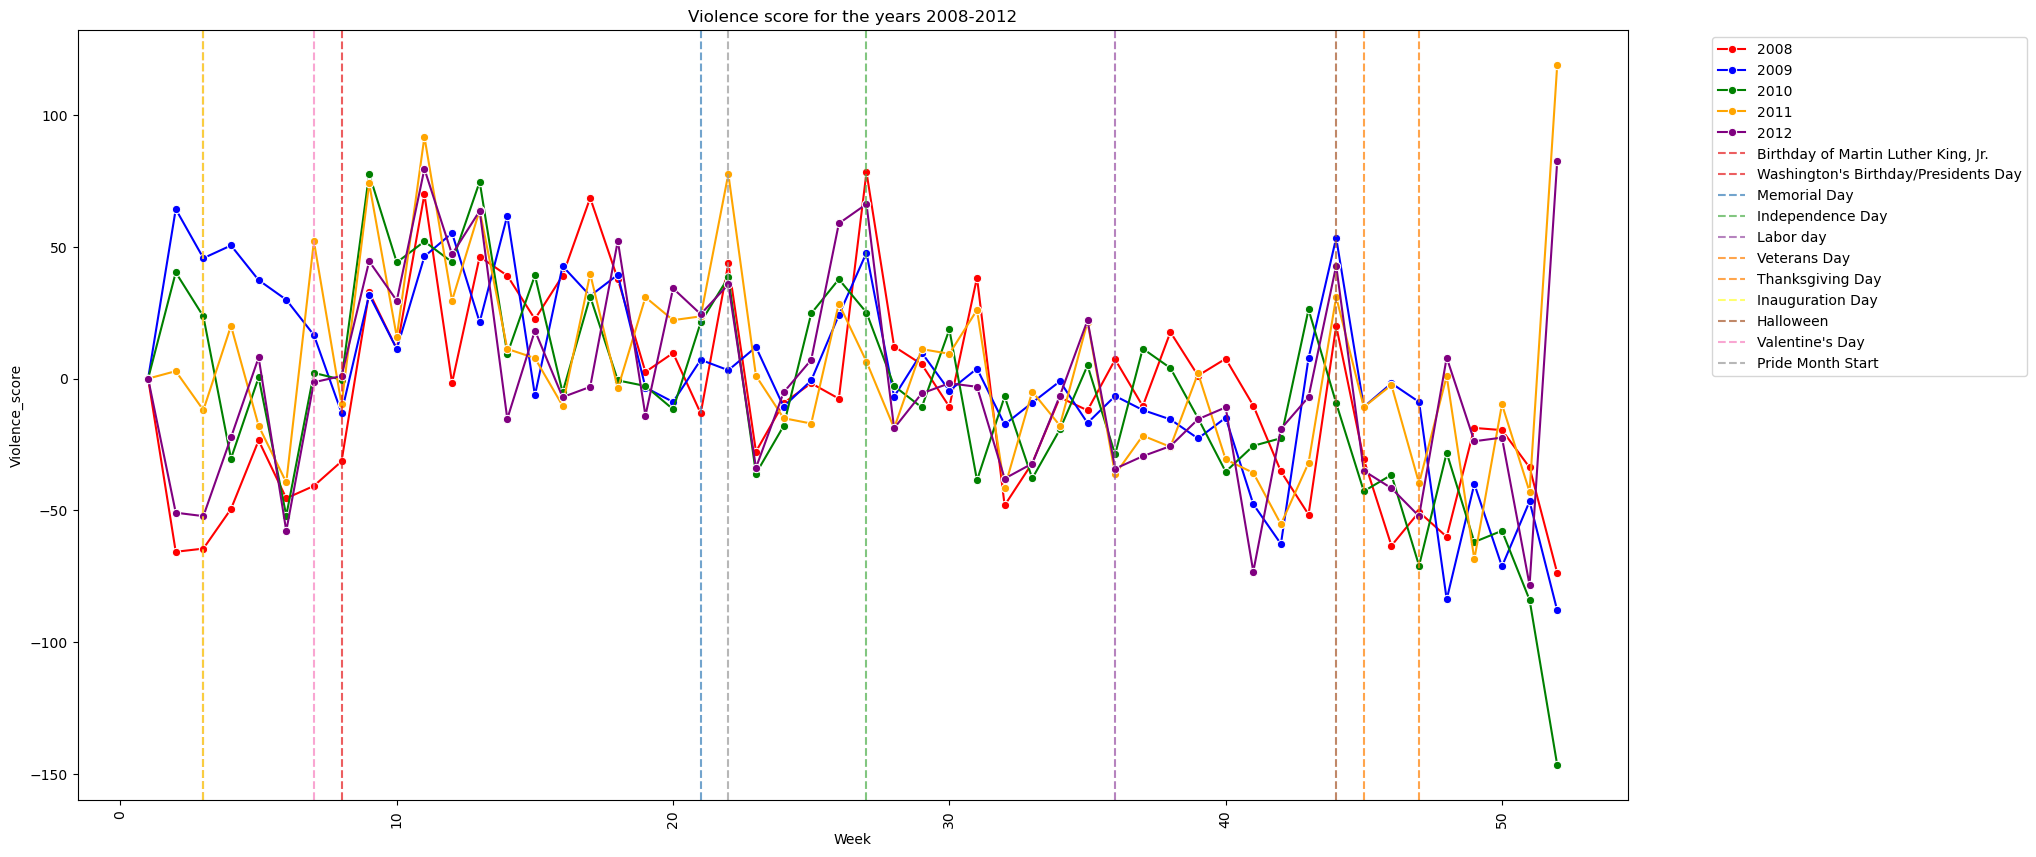

In [24]:

from matplotlib.cm import get_cmap
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}


# Specific weeks
highlighted_weeks = {
    'Birthday of Martin Luther King, Jr.':3,
    "Washington's Birthday/Presidents Day" :8,
    "Memorial Day":21,
    "Independence Day":27,
    "Labor day":36,
    "Veterans Day":45,
    "Thanksgiving Day":47,
    'Inauguration Day':3,
    'Halloween': 44,  # Halloween falls on week 44
    'Valentine\'s Day': 7,  # Valentine's Day falls on week 7
    'Pride Month Start': 22  # Pride Month starts in week 22
}

# Use a colormap (e.g., tab20)
cmap = plt.colormaps.get_cmap("Set1")  # Get a palette with 20 distinct colors
distinct_colors = [cmap(i / len(highlighted_weeks)) for i in range(len(highlighted_weeks))]


combined_df = z_scores_merged[z_scores_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [25]:
result_df = z_scores_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')


Per year

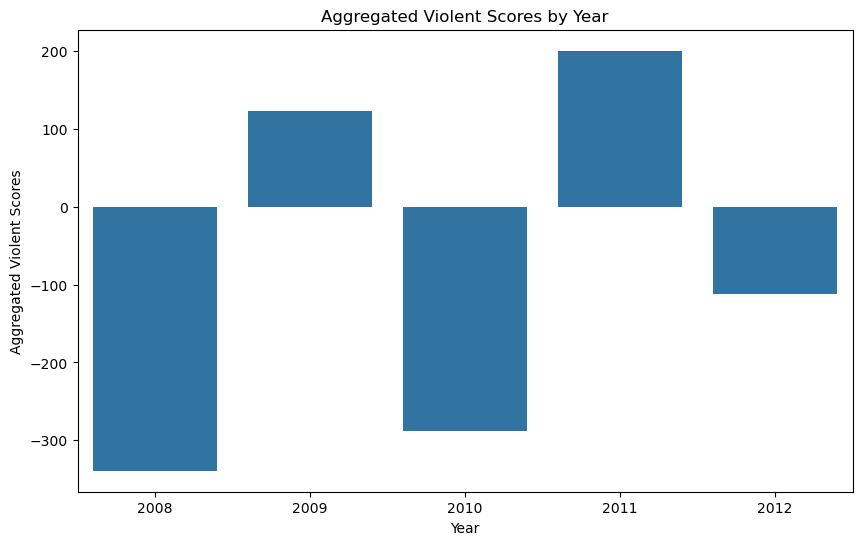

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

# Plots for count violent scores

In [27]:
import warnings
def violence_score_all_states_count(directory_path: str, start_year: int, end_year: int, start_week: int, stop_week: int, 
                                   ratio: bool = False, offenses: list = ['Assault Offenses', 'Robbery', 'Sex Offenses', 'Kidnapping/Abduction', 'Arson', 'Homicide Offenses']) -> dict:
   

    violence_scores_per_state = {}

    # Iterate through directory
    for filename in os.listdir(directory_path):

        state_scores_years = []

        # Check for .csv extension
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)

            # Extract state name (everything before first "_")
            state_name = filename.split("_")[0]
            dict_key = f"ARDL_{state_name}"

            # Load into dataframe
            real_violence_per_state = pd.read_csv(file_path, sep=",")

            with warnings.catch_warnings():

                warnings.filterwarnings("ignore")

                for year in range(start_year, end_year + 1):

                    # Compute real-life violence score for this state and year
                    weekly_score = real_life_violence_score_count(real_violence_per_state, year, start_week, stop_week, ratio)

                    # Convert to DataFrame
                    weekly_score_df = weekly_score.reset_index(name='violence_score')
                    weekly_score_df['year'] = year
                    state_scores_years.append(weekly_score_df)

                # Store in dict
                violence_scores_per_state[dict_key] = pd.concat(state_scores_years, axis=0, ignore_index=True)

    # Concatenate all dataframes for all states
    violence_scores_concat = pd.concat(violence_scores_per_state.values(), ignore_index=True)

    # Group by "Year" and "Week", sum up the violence scores
    violence_scores_merged = violence_scores_concat.groupby(["year", "week"], as_index=False).agg({"violence_score": "sum"})

    # Renaming the columns for consistency
    violence_scores_merged.columns.values[0] = "Year"
    violence_scores_merged.columns.values[1] = "Week"
    violence_scores_merged.columns.values[2] = "Violence_score"

    return violence_scores_merged


In [28]:
violent_score_ratio_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=True)
violent_score_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=False)

Accross years per week

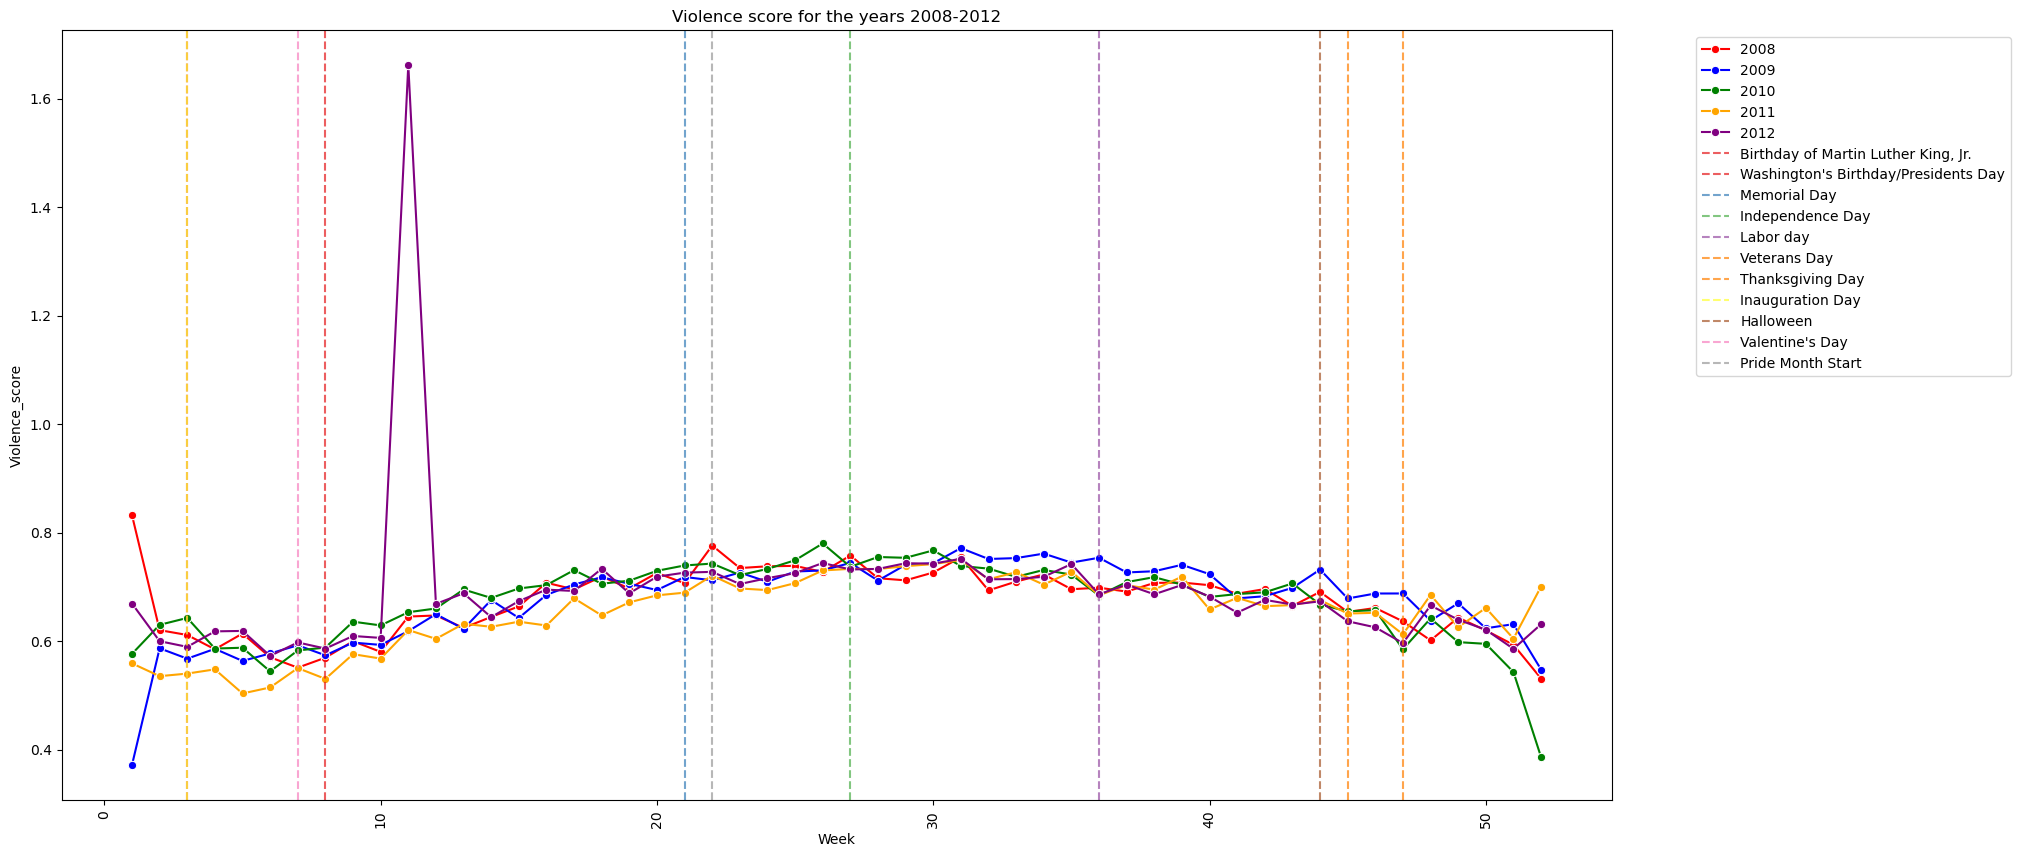

In [29]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df_ratio = violent_score_ratio_merged[violent_score_ratio_merged.Year.isin(years)]

plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df_ratio, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [30]:
result_df_ratio = violent_score_ratio_merged.groupby('Year')["Violence_score"].sum()
result_df_ratio = result_df_ratio.reset_index(name='Aggregated violent scores')


Per year

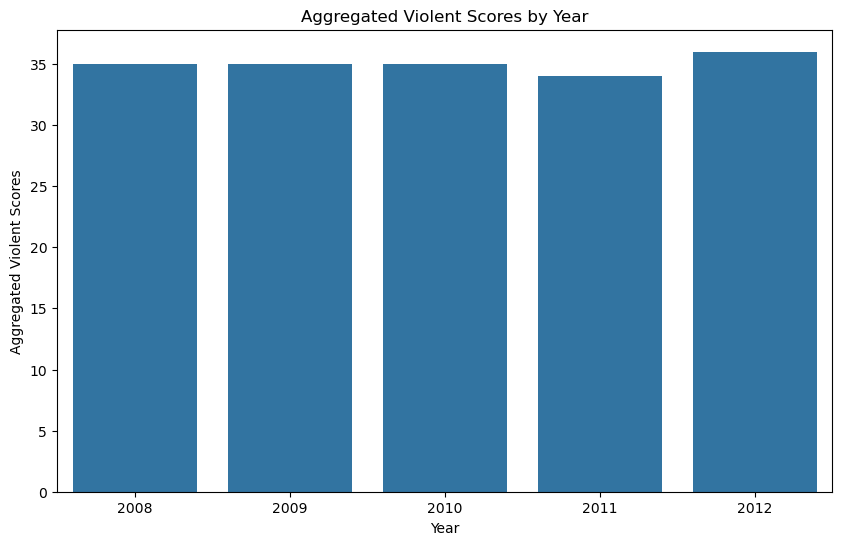

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df_ratio, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

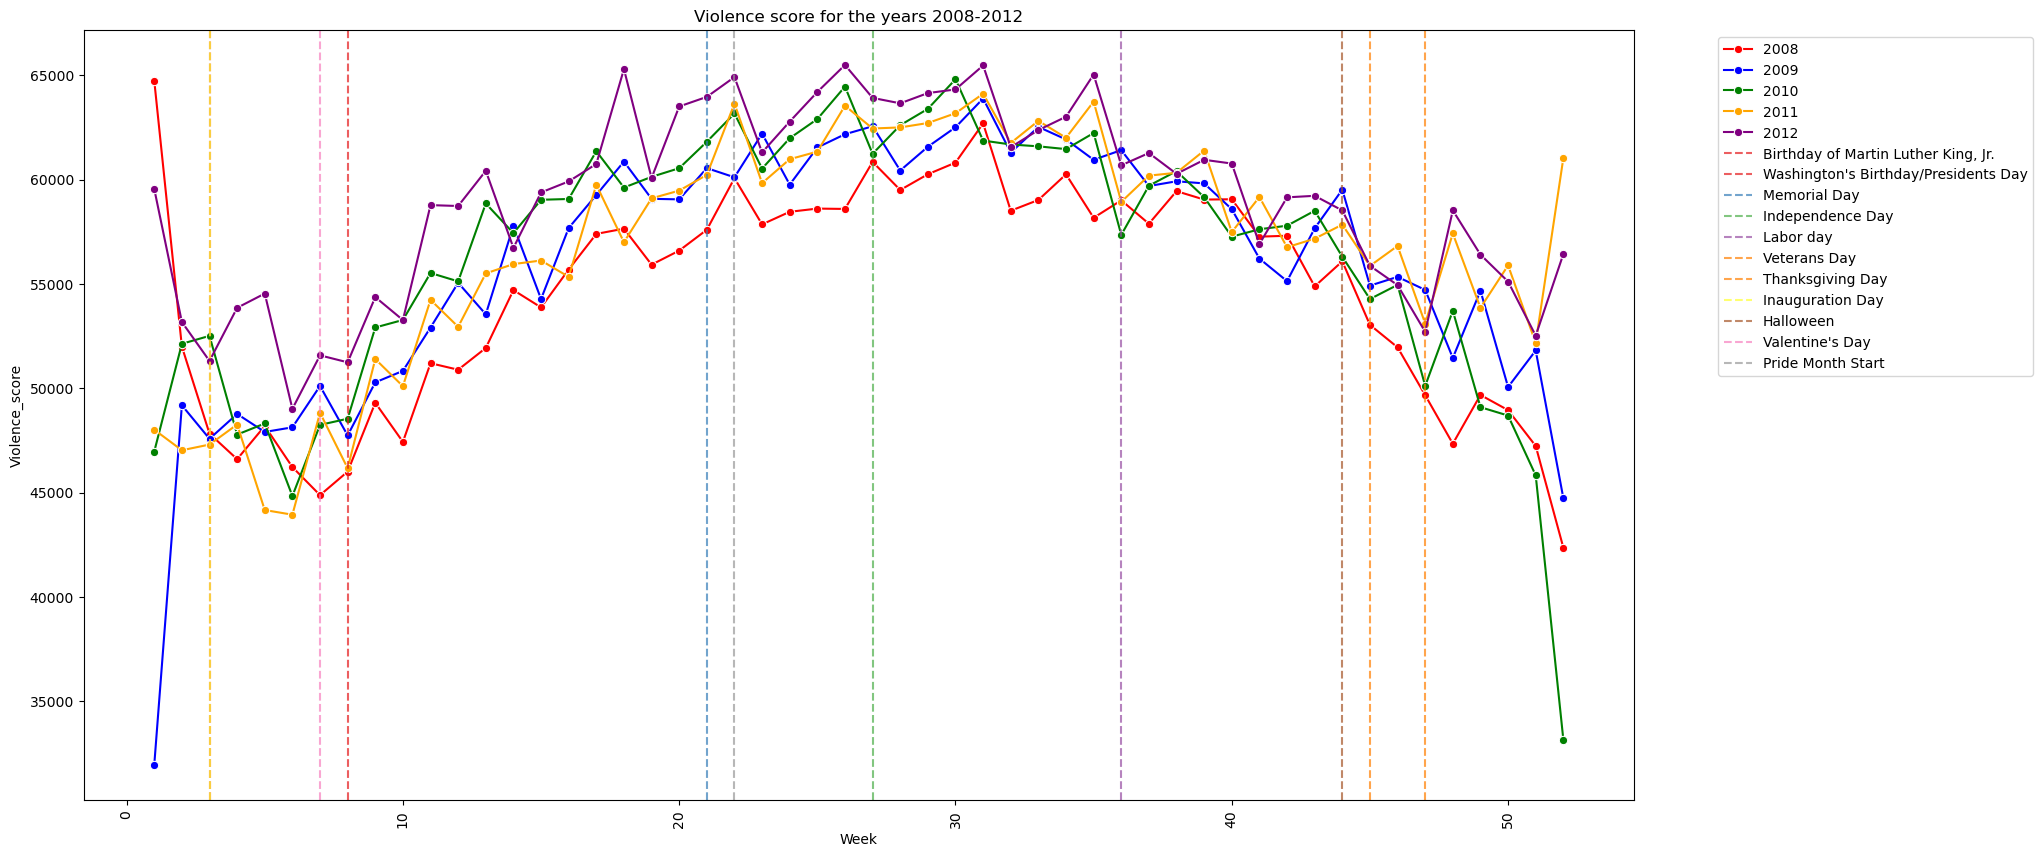

In [32]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df = violent_score_merged[violent_score_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [33]:
result_df = violent_score_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')


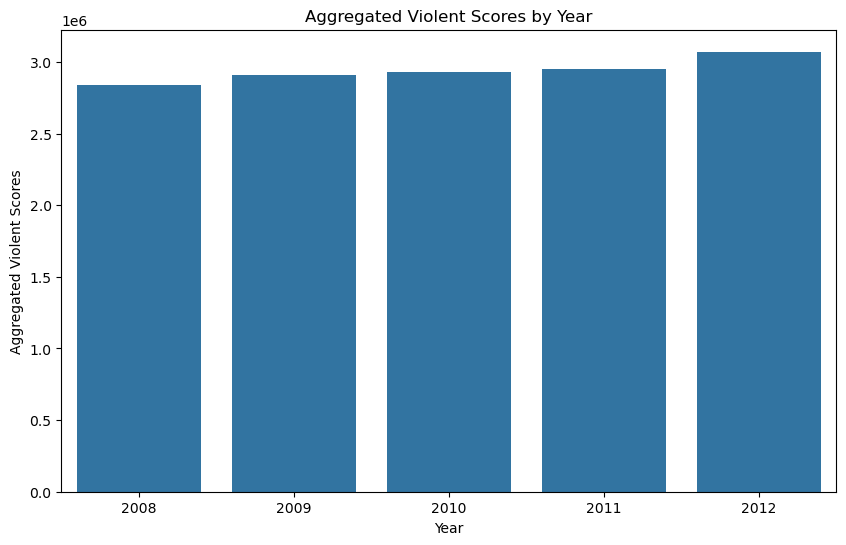

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()